This notebook shows how to extract the estimated normalized entropy rate (nER) formulated in [Tejedor et al.](https://www.pnas.org/content/114/44/11651) from our channel network. The wikipage for the nER (without the discussion of the normalization factor) is [here](https://en.wikipedia.org/wiki/Entropy_rate).

In [36]:
import geopandas as gpd
import networkx as nx
from pathlib import Path

import matplotlib.pyplot as plt
from orinoco import (export_edges_to_geodataframe, 
                     export_nodes_to_geodataframe, 
                     dfs_line_search, 
                     direct_channel_network_using_distance,
                     get_extent,
                     get_cropped_profile)
from orinoco.plot import get_extent, make_map, rand_cmap
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import numpy as np
import scipy
import rasterio
from matplotlib.lines import Line2D
from shapely.geometry import Point

In [37]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [38]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

In [39]:
plot_entropy = Path('plots/entropy')
plot_entropy.mkdir(exist_ok=True, parents=True)

In [40]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')

In [41]:
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson')
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson')

# Obtain Directed Acyclic Network with Single Source

Let's select the node with the label we want (easier to specify label than node from QGIS due to precision issues).

In [42]:

label_value = 361
nodes_with_label = [node for node, data in chanG.nodes(data=True) if data['label'] == label_value]
nodes_with_label[0], len(nodes_with_label)

((655447.4137931034, 3280608.908045977), 1)

Using this SO [post](https://stackoverflow.com/a/13934101/2348348) from the original author of NetworkX, we can obtain the relevant subgraph.

In [43]:
source_node = nodes_with_label[0]
downstream_nodes = list(nx.shortest_path(chanG, source_node).keys())
chanG_sub = chanG.subgraph([source_node] + downstream_nodes).copy()
# Because some noddes are no longer junctions, this ensures the segments correspond to the current graph.
chanG_sub = direct_channel_network_using_distance(chanG_sub.to_undirected())

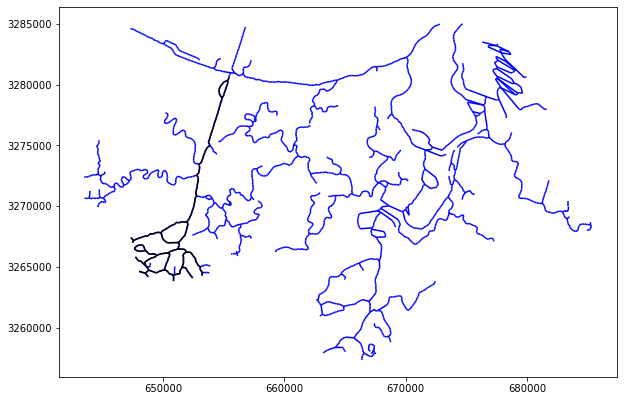

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_df.plot(ax=ax, edgecolor='blue')

edges_df_sub = export_edges_to_geodataframe(chanG_sub, edges_df.crs)
nodes_df_sub = export_nodes_to_geodataframe(chanG_sub, edges_df.crs)

edges_df_sub.plot(ax=ax, edgecolor='black')

In [45]:
edges_df_sub.to_file('test')

In [46]:
# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(chanG, 
#         pos=pos, 
#         node_size=1,
#         edge_width=.25,
#         alpha=.2,
#         arrows=True,
#         arrowsize=10,
#         ax=ax,
#         node_color='blue')
# nx.draw(chanG_sub, 
#         pos=pos, 
#         node_size=1,
#         arrows=True,
#         arrowsize=10,
#         ax=ax,
#         node_color='blue')


# Merge at Junctions

In [47]:
width_dict = nx.get_edge_attributes(chanG, 'width_m')
weight_dict = nx.get_edge_attributes(chanG, 'weight')

The depth-first search lines searches by edges and yields a list of edges in a partition.

In [48]:
lines = list(dfs_line_search(chanG_sub, source_node))

In [49]:
edge_data_merged = {(line[0][0], line[-1][1], k):  {'segment_id': k,
                                                    # Average width along edge segment
                                                    'width': np.mean([width_dict[edge] for edge in line]),
                                                    # Total Length of Line
                                                    'weight': np.sum([weight_dict[edge] for edge in line])}
                     for (k, line) in enumerate(lines)

                    }
current_edge_index = len(lines)
current_edge_index

31

In [50]:
chanG_merged = nx.MultiDiGraph()
chanG_merged.add_edges_from(edge_data_merged.keys())
nx.set_edge_attributes(chanG_merged, edge_data_merged)

In [51]:
pos = {node: node for node in chanG.nodes()}

In [52]:
source_node

(655447.4137931034, 3280608.908045977)

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


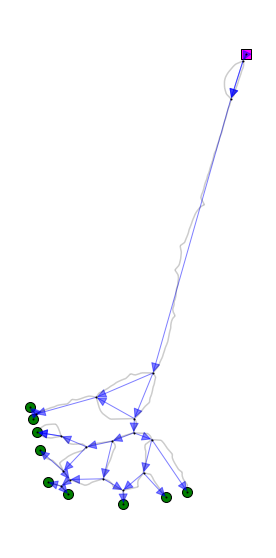

In [53]:
fig, ax = plt.subplots(figsize=(6, 10))


#edges_df.plot(ax=ax, edgecolor='black', alpha=.2)


nx.draw(chanG_merged, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(chanG_merged.edges()),
        arrows=True,
        arrowsize=20,
        ax=ax,
        node_color='black')

edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)

nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')

nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')




# Connect Source and Outlets

In [54]:
outlets = [node for node, data in chanG_sub.nodes(data=True) if data['interface_adj']]
len(outlets)

9

In [55]:
stationary_distribution_graph = chanG_merged.copy()
edges_outlet_to_source = [(outlet, source_node, k + current_edge_index) 
                            for k, outlet in enumerate(outlets)]
stationary_distribution_graph.add_edges_from(edges_outlet_to_source)
nx.set_edge_attributes(stationary_distribution_graph,
                      {edge: {'width': 1.} for edge in edges_outlet_to_source})
current_edge_index = len(lines) + len(outlets)

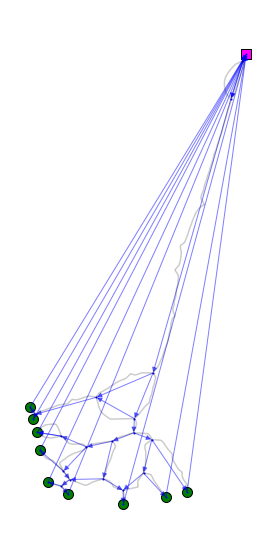

In [56]:
fig, ax = plt.subplots(figsize=(5, 10))



nx.draw(stationary_distribution_graph, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(stationary_distribution_graph.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)

nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')
nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')

# Compute Stationary Distribution and nER

In [57]:
nodes_from_multigraph = list(stationary_distribution_graph.nodes())

In [58]:
stationary_distribution_graph_undirected = stationary_distribution_graph.to_directed()
adj_mat = nx.adj_matrix(stationary_distribution_graph_undirected, 
                        nodelist=nodes_from_multigraph,
                        weight='width')
transition_matrix = np.array((adj_mat / adj_mat.sum(axis=1)))

In [59]:
import warnings

def compute_normalized_entropy_rate(transition_matrix):
    eig_values, eig_vec_l, _ = scipy.linalg.eig(transition_matrix, left=True)
    pi = eig_vec_l[:, 0].real
    pi = (pi / np.sum(pi))
    
    #enusre largest eignvalue is 1
    assert(np.abs(eig_values[0] - 1) < 1e-10)
    # ensure eigenvector is real
    assert(np.linalg.norm(eig_vec_l[:, 0].astype(float) - eig_vec_l[:, 0]) < 1e-10)
    
    log_T = np.log(transition_matrix, where=(transition_matrix>0), out=np.zeros(transition_matrix.shape))
    deg = np.sum((transition_matrix > 0), axis=1)
    normalized_er = np.einsum('ij,ij->i', transition_matrix, log_T) 
    normalized_er /=  np.log(1./deg, where=(deg > 1), out=np.ones(deg.shape))
    normalized_er = np.dot(normalized_er, pi)
    return normalized_er

In [60]:
compute_normalized_entropy_rate(transition_matrix)

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


0.3973208934583104

# Plot for Report

In [61]:
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')


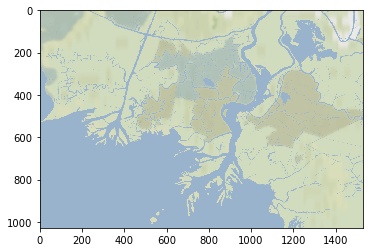

In [62]:
with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    arr = ds.read().transpose([1, 2, 0])[..., :3]
    profile_4326 = ds.profile
plt.imshow(arr)

In [63]:
sy, sx =  np.s_[:675], np.s_[100:775],
profile_c = get_cropped_profile(profile_4326, sx, sy)

In [64]:
extent = get_extent(profile_c['transform'], profile_c['width'], profile_c['height'])
# xmin, xmax, ymax, ymin
extent

[-91.5144, -91.3119, 29.683199999999996, 29.480699999999995]

In [65]:
edges_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
nodes_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})
nodes_df_source_4326 = nodes_df_source.to_crs({'init':'epsg:4326'})
edges_df_sub_4326 = edges_df_sub.to_crs({'init':'epsg:4326'})
nodes_df_sub_4326 = nodes_df_sub.to_crs({'init':'epsg:4326'})

In [66]:
H = chanG_sub.copy()

In [79]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'Source',
                          markerfacecolor='blue',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]



legend_elements += [Line2D([0], 
                          [0], 
                          marker='o',
                          color='w',
                          label=f'Outlet',
                          markerfacecolor='green',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]


legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           #markerfacecolor=scalarMap.to_rgba(k),
                           #markeredgecolor='black',
                           #edgecolor='black',
                           markersize=15)]
legend_elements += [Line2D([0], 
                          [0], 
                          marker=None,
                          color='black',
                          label='Subgraph',
                          linewidth=2,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

legend_elements += [Line2D([0], 
                          [0], 
                          marker=None,
                          color='blue',
                          label='Full network',
                          linewidth=2,
                          #markerfacecolor=scalarMap.to_rgba(k),
                          #markeredgecolor='black',
                          #edgecolor='black',
                          markersize=10)]

In [80]:
# Slower, but equivalent

# from pyproj import Proj, transform
# inProj = Proj(init=original_crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

geom = list(map(lambda p: Point(*p), H.nodes()))
nodes_df_temp = gpd.GeoDataFrame(geometry=geom, crs=edges_df.crs)
nodes_df_temp['geometry_r'] = nodes_df_temp.geometry.to_crs({'init':'epsg:4326'})
nodes_df_temp['geometry_r_coords'] = nodes_df_temp['geometry_r'].map(lambda p: p.coords[0])
nodes_df_temp['geometry_coords'] = nodes_df_temp['geometry'].map(lambda p: p.coords[0])
nodes_df_temp.head()
pos_r = nodes_df_temp.set_index('geometry_coords').to_dict()['geometry_r_coords']

In [81]:
from orinoco import dfs_line_search

interface_nodes = [node for node, data in H.node(data=True) if data['interface_adj']]
node_data = dict(H.nodes(data=True))

def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]
lines = list(dfs_line_search_with_interface(H.to_undirected(), random_source))

edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

32

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


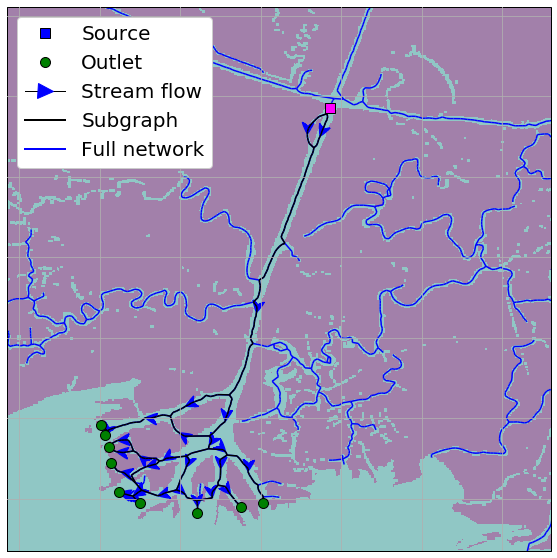

In [83]:
fig, ax = make_map(projection=ccrs.PlateCarree(),
                   figsize=(10, 10),
                   labels=False
                   )
ax.set_extent(extent, crs=ccrs.PlateCarree())

ax.imshow(water_mask[sy, sx], alpha=.5, 
          zorder=0, 
          extent=extent,
          transform=ccrs.PlateCarree(),
          cmap='viridis', 
          vmax=2)




edges_df_4326.plot(ax=ax, edgecolor='blue', alpha=1)


edges_df_sub_4326.plot(ax=ax, edgecolor='black', alpha=1)

nodes_df_sub_4326[nodes_df_sub_4326.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black', zorder=3)

ins, outs = zip(*edges_with_arrows)
H2 = H.subgraph(list(set(ins + outs)))

nodes_df_source_4326.plot(color='blue', 
                          ax=ax, 
                          markersize=100, 
                          facecolor='magenta', 
                          edgecolor='black', 
                          marker='s', 
                          zorder=4)

nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )

ax.legend(handles=legend_elements, loc='upper left', fontsize=20,  framealpha=1)
plt.savefig(plot_entropy/'entropy_fig.png')